# scVI harmonization for integration of different datasets
### tutorial here: https://scvi.readthedocs.io/en/stable/tutorials/harmonization.html
## scVI is unsupervised, whereas SCANVI is semi-supervised (sharing data among clusters) --> I'm more interested in scVI

In [1]:
import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc

from scvi.dataset.dataset import GeneExpressionDataset
from scvi.inference import UnsupervisedTrainer
from scvi.models import SCANVI, VAE

from umap import UMAP

import torch

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

# Use GPU
use_cuda = True

import os
import anndata

# Getting simulations as hda5 (should only have to do this once)

In [2]:
sim_folder = 'D:Robin/simulated-nuclei/final_regulons/TF_times_3_good_replicates'
sim_matrix_fname = os.path.join(sim_folder,'sim_ex_mtx.p')
sim_table_fname = os.path.join(sim_folder,'sim_id_table.p')
sim_ad_fname = os.path.join(sim_folder,'sim_ad')

In [3]:
sim_matrix = pd.read_pickle(open(sim_matrix_fname,'rb'))
sim_table = pd.read_pickle(open(sim_table_fname,'rb'))

In [4]:
sim_ad = sc.AnnData(sim_matrix)

In [5]:
sim_table['specific_dataset']

PCX_3_0       PCX_3
PCX_3_1       PCX_3
PCX_3_2       PCX_3
PCX_3_3       PCX_3
PCX_3_4       PCX_3
              ...  
AON_2_1495    AON_2
AON_2_1496    AON_2
AON_2_1497    AON_2
AON_2_1498    AON_2
AON_2_1499    AON_2
Name: specific_dataset, Length: 3000, dtype: object

In [6]:
#sim_ad.obs['specific_dataset'] = sim_table['specific_dataset']
sim_ad.obs['specific_dataset'] = list(sim_table['specific_dataset'])
sim_ad.obs['general_dataset'] = list(sim_table['general_dataset'])

In [7]:
sim_ad.obs

specific_dataset general_dataset
PCX_3_0               PCX_3             PCX
PCX_3_1               PCX_3             PCX
PCX_3_2               PCX_3             PCX
PCX_3_3               PCX_3             PCX
PCX_3_4               PCX_3             PCX
...                     ...             ...
AON_2_1495            AON_2             AON
AON_2_1496            AON_2             AON
AON_2_1497            AON_2             AON
AON_2_1498            AON_2             AON
AON_2_1499            AON_2             AON

[3000 rows x 2 columns]

In [8]:
sim_ad.write_h5ad(sim_ad_fname,compression='gzip')

... storing 'specific_dataset' as categorical
... storing 'general_dataset' as categorical


# Getting standard single nuclei as hda5 (should only have to do this once)

In [100]:
st_folder = 'D:Robin/Single_seq_data'
st_matrix_fname = os.path.join(st_folder,'R1_R3_counts.p')
st_table_fname = os.path.join(st_folder,'cells_and_louvain_R1_R3_ids.p')
st_ad_fname = os.path.join(st_folder,'R1_R3_counts_ad')

In [24]:
st_folder = 'D:Robin/Single_seq_data/final_nuclei'
st_matrix_fname = os.path.join(st_folder,'st_data.p')
st_table_fname = os.path.join(st_folder,'st_table.p')
st_ad_fname = os.path.join(st_folder,'subcluster.h5ad')

In [294]:
st_matrix = pd.read_pickle(open(st_matrix_fname,'rb'))
st_table = pd.read_pickle(open(st_table_fname,'rb'))

In [295]:
st_ad = sc.AnnData(st_matrix)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [296]:
st_table

orig.ident  nCount_RNA  nFeature_RNA sampleID  percent.mt  \
AAACGAAGTAGCGTCC-1         R1       10981          3303       R1    0.091066   
AAACGCTTCCCATAAG-1         R1       11484          2878       R1    0.034831   
AAACGCTTCTACCCAC-1         R1       16589          3857       R1    0.042197   
AAAGAACCATCTGTTT-1         R1       22333          4668       R1    0.008955   
AAAGGATAGCACCGTC-1         R1       23540          5040       R1    0.016992   
...                       ...         ...           ...      ...         ...   
TTTGACTCATCGGAGA-1         R3       10713          3011       R3    0.028003   
TTTGATCAGTTGTAGA-1         R3       13635          3622       R3    0.022002   
TTTGGTTGTGACATCT-1         R3       10919          2629       R3    0.036633   
TTTGTTGAGGCCTGAA-1         R3       16237          3858       R3    0.000000   
TTTGTTGTCTCATTGT-1         R3       26195          5023       R3    0.053445   

                   included  nCount_SCT  nFeature_SCT  all DF_Classification  \
AAACGAAGTAGCGTCC-1        +        8825          3301  all           Singlet   
AAACGCTTCCCATAAG-1        +        8776          2875  all           Singlet   
AAACGCTTCTACCCAC-1        +        8996          3498  all           Singlet   
AAAGAACCATCTGTTT-1        +        8719          3238  all           Singlet   
AAAGGATAGCACCGTC-1        +        8770          3530  all           Singlet   
...                     ...         ...           ...  ...               ...   
TTTGACTCATCGGAGA-1        +       10676          3009  all           Singlet   
TTTGATCAGTTGTAGA-1        +       11330          3619  all           Singlet   
TTTGGTTGTGACATCT-1        +       10752          2625  all           Singlet   
TTTGTTGAGGCCTGAA-1        +       11257          3828  all           Singlet   
TTTGTTGTCTCATTGT-1        +       11346          4008  all           Doublet   

                    ...        sub_clusters_ExNeurons_names  \
AAACGAAGTAGCGTCC-1  ...  sub_clusters_ExNeurons_1_Cluster_0   
AAACGCTTCCCATAAG-1  ...  sub_clusters_ExNeurons_1_Cluster_0   
AAACGCTTCTACCCAC-1  ...  sub_clusters_ExNeurons_1_Cluster_6   
AAAGAACCATCTGTTT-1  ...  sub_clusters_ExNeurons_1_Cluster_0   
AAAGGATAGCACCGTC-1  ...  sub_clusters_ExNeurons_1_Cluster_0   
...                 ...                                 ...   
TTTGACTCATCGGAGA-1  ...  sub_clusters_ExNeurons_1_Cluster_0   
TTTGATCAGTTGTAGA-1  ...  sub_clusters_ExNeurons_1_Cluster_0   
TTTGGTTGTGACATCT-1  ...  sub_clusters_ExNeurons_1_Cluster_1   
TTTGTTGAGGCCTGAA-1  ...  sub_clusters_ExNeurons_1_Cluster_0   
TTTGTTGTCTCATTGT-1  ...  sub_clusters_ExNeurons_1_Cluster_6   

                    UMAP_1_sub_clusters_ExNeurons  \
AAACGAAGTAGCGTCC-1                      -4.291805   
AAACGCTTCCCATAAG-1                       0.950718   
AAACGCTTCTACCCAC-1                       4.022650   
AAAGAACCATCTGTTT-1                      -1.015267   
AAAGGATAGCACCGTC-1                      -2.655362   
...                                           ...   
TTTGACTCATCGGAGA-1                      -1.535565   
TTTGATCAGTTGTAGA-1                       0.155162   
TTTGGTTGTGACATCT-1                       4.422424   
TTTGTTGAGGCCTGAA-1                      -0.805312   
TTTGTTGTCTCATTGT-1                       2.644722   

                    UMAP_2_sub_clusters_ExNeurons         sub_subclustering  \
AAACGAAGTAGCGTCC-1                      -3.820229                       NaN   
AAACGCTTCCCATAAG-1                      -5.447897                       NaN   
AAACGCTTCTACCCAC-1                      11.111612                       NaN   
AAAGAACCATCTGTTT-1                      -5.637583                       NaN   
AAAGGATAGCACCGTC-1                      -6.103374                       NaN   
...                                           ...                       ...   
TTTGACTCATCGGAGA-1                      -4.244167                       NaN   
TTTGATCAGTTGTAGA-1                      -3.934468                      

In [298]:
st_ad.obs['louvain'] = st_table['louvain']
#st_ad.obs['no_num'] = st_table['no_num']

In [301]:
st_ad.obs

louvain
AAACGAAGTAGCGTCC-1      T1
AAACGCTTCCCATAAG-1      T1
AAACGCTTCTACCCAC-1     ET2
AAAGAACCATCTGTTT-1      T1
AAAGGATAGCACCGTC-1      T1
...                    ...
TTTGACTCATCGGAGA-1      T1
TTTGATCAGTTGTAGA-1      T1
TTTGGTTGTGACATCT-1      M1
TTTGTTGAGGCCTGAA-1      T1
TTTGTTGTCTCATTGT-1     ET2

[7504 rows x 1 columns]

In [16]:
fname = 'D:Robin/Single_seq_data/final_nuclei/subcluster.loom'
st_ad = anndata.read_loom(fname,sparse=False)

ValueError: Row attribute 'var_names' dtype object is not allowed
Column attribute 'DF_Classification' dtype object is not allowed
Column attribute 'all' dtype object is not allowed
Column attribute 'cellIdent' dtype object is not allowed
Column attribute 'clustIdent' dtype object is not allowed
Column attribute 'hmIdent2' dtype object is not allowed
Column attribute 'included' dtype object is not allowed
Column attribute 'louvain' dtype object is not allowed
Column attribute 'obs_names' dtype object is not allowed
Column attribute 'orig.ident' dtype object is not allowed
Column attribute 'sampleID' dtype object is not allowed
Column attribute 'sub_clusters_ExNeurons_names' dtype object is not allowed
Column attribute 'sub_sub_clusters_ExNeurons_names' dtype object is not allowed
Column attribute 'sub_subclustering' dtype object is not allowed
Column attribute 'subclustering' dtype object is not allowed
For help, see http://linnarssonlab.org/loompy/format/
D:Robin/Single_seq_data/final_nuclei/subcluster.loom does not appead to be a valid Loom file according to Loom spec version '2.0.1'

In [ ]:
st_ad.write_h5ad(st_ad_fname,compression='gzip')

# Loading data into scVI

In [3]:
from scvi.dataset import AnnDatasetFromAnnData
sim_ad = anndata.read_h5ad(sim_ad_fname)

In [4]:
sim_ad.obs.specific_dataset.unique()

[PCX_3, AON_2]
Categories (2, object): [PCX_3, AON_2]

In [71]:
#good_replicates = [cell for cell in sim_ad.obs.index if sim_ad.obs.loc[cell,'specific_dataset'] != 'PCX_1']

In [72]:
sim_ad = sim_ad[good_replicates]

In [73]:
sim_ad

View of AnnData object with n_obs × n_vars = 2500 × 5049
    obs: 'specific_dataset', 'general_dataset'

In [25]:
st_ad = anndata.read_h5ad(st_ad_fname)

In [5]:
st_ad = anndata.read_h5ad('D:Robin/Single_seq_data/final_nuclei/mitral.h5ad')

In [6]:
simulated = AnnDatasetFromAnnData(ad = sim_ad)
standard = AnnDatasetFromAnnData(ad = st_ad)

[2020-07-13 01:11:40,271] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-13 01:11:40,278] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-13 01:11:40,653] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-13 01:11:40,715] INFO - scvi.dataset.dataset | Downsampled from 3000 to 3000 cells
[2020-07-13 01:11:41,186] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-13 01:11:41,189] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-13 01:11:42,763] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-13 01:11:43,031] INFO - scvi.dataset.dataset | Downsampled from 2161 to 2161 cells


In [17]:
from scvi.dataset import LoomDataset

In [ ]:
#standard = LoomDataset('D:Robin/Single_seq_data/final_nuclei/subcluster.loom')

## concatenate data

In [7]:
all_dataset = GeneExpressionDataset()
all_dataset.populate_from_datasets([standard, simulated])

[2020-07-13 01:11:47,478] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2020-07-13 01:11:47,480] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2020-07-13 01:11:47,536] INFO - scvi.dataset.dataset | Keeping 5049 genes
[2020-07-13 01:11:48,012] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-13 01:11:48,133] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-13 01:11:48,135] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-13 01:11:48,641] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-13 01:11:48,840] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-13 01:11:48,842] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-13 01:11:49,277] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-13 01:11:49,279] INFO - s

# scVI (single-cell Variational Inference)

### *scVI* is a hierarchical Bayesian model for single-cell RNA sequencing data with conditional distributions parametrized by neural networks. Working as a hybrid between a neural network and a bayesian network, scVI performs data harmonization. VAE refers to variational auto-encoders for single-cell gene expression data. scVI is similar to VAE as it tries to bring a more suitable structure to the latent space. While VAE allows users to make observations in a semi-supervised fashion, scVI is easier to train and specific cell-type labels for the dataset are not required in the pure unsupervised case.

## Define the model, train (should take ~30 minutes depending on number of epochs)

In [8]:
vae = VAE(all_dataset.nb_genes, n_batch=all_dataset.n_batches, n_labels=all_dataset.n_labels,
          n_hidden=128, n_latent=30, n_layers=2, dispersion='gene')

trainer = UnsupervisedTrainer(vae, all_dataset, train_size=1.0)
n_epochs = 1000
trainer.train(n_epochs=n_epochs)

[2020-07-13 01:11:56,459] INFO - scvi.inference.inference | KL warmup for 400 epochs


## can optionally save and then load trained model

In [9]:
fn = '1000_epochs_mitral_only'

In [11]:
fname = os.path.join(sim_folder,fn,'harmonization.vae.allgenes.30.model.pkl')
torch.save(trainer.model.state_dict(),fname)
# trainer.model.load_state_dict(torch.load(save_path+'harmonization.vae.allgenes.30.model.pkl'))

In [ ]:
trainer.model.eval()

## obtain latent space

In [12]:
full = trainer.create_posterior(trainer.model, all_dataset, indices=np.arange(len(all_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

## Plot UMAP

In [13]:
latent_u = UMAP(spread=2).fit_transform(latent)

In [14]:
cm = LinearSegmentedColormap.from_list(
        'my_cm', ['deepskyblue', 'hotpink'], N=2)
fig, ax = plt.subplots(figsize=(5, 5))
order = np.arange(latent.shape[0])
random.shuffle(order)
ax.scatter(latent_u[order, 0], latent_u[order, 1],
           c=all_dataset.batch_indices.ravel()[order],
           cmap=cm, edgecolors='none', s=5)
plt.axis("off")
fig.set_tight_layout(True)

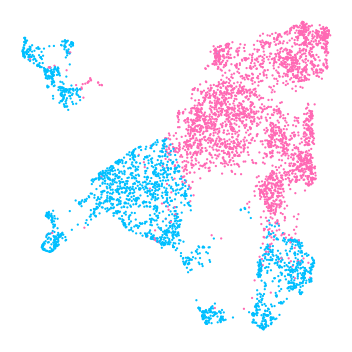

In [15]:
fig

In [16]:
fname = os.path.join(sim_folder,fn,'scVI_alginment_origin')
fig.savefig(fname,bbox_inches='tight')

### Trying to color by dataset/louvain

In [17]:
#get latent space as AnnData (tutorial does this for clustering)
adata_latent = sc.AnnData(latent)

In [18]:
#trying to populate this Anndata with louvain/dataset information
#made object with standard,simulated - hoping that is the order

In [19]:
#imported_labels = pd.concat([st_ad.obs['louvain'],sim_ad.obs['specific_dataset']])
imported_labels = pd.concat([st_ad.obs['louvain'],sim_ad.obs['general_dataset']])

In [20]:
imported_labels.index

Index(['AAAGGGCTCGTAGCTA-1', 'AAAGGTATCTATACGG-1', 'AAAGTCCCATCGATGT-1',
       'AACAAGATCGCTACGG-1', 'AACCAACCAGAGTTCT-1', 'AACCATGAGTGTTGAA-1',
       'AACGGGATCCTTTAGT-1', 'AAGAACAAGTGAGGTC-1', 'AAGATAGCAGTAGGAC-1',
       'AAGCGAGGTGTAGCAG-1',
       ...
       'AON_2_1490', 'AON_2_1491', 'AON_2_1492', 'AON_2_1493', 'AON_2_1494',
       'AON_2_1495', 'AON_2_1496', 'AON_2_1497', 'AON_2_1498', 'AON_2_1499'],
      dtype='object', length=5161)

In [21]:
adata_latent.obs.index = imported_labels.index

In [22]:
adata_latent.obs['imported_labels'] = imported_labels

In [23]:
adata_latent.obs

imported_labels
AAAGGGCTCGTAGCTA-1              M2
AAAGGTATCTATACGG-1              M2
AAAGTCCCATCGATGT-1              M2
AACAAGATCGCTACGG-1              M2
AACCAACCAGAGTTCT-1              M1
...                            ...
AON_2_1495                     AON
AON_2_1496                     AON
AON_2_1497                     AON
AON_2_1498                     AON
AON_2_1499                     AON

[5161 rows x 1 columns]

In [24]:
adata_latent.obs.imported_labels.unique()

array(['M2', 'M1', 'M3', 'PCX', 'AON'], dtype=object)

In [25]:
clusters = adata_latent.obs.imported_labels.values

In [26]:
len(clusters)

5161

In [27]:
######R1+R3

ordered_names = ['4:M1','6:M2','2:M2B','7:M3','5:T1','0:T2','1:T3','10:ET1','8:ET2','11:PG','3:IN','9:?','12:??',
                'PCX_1','PCX_2','PCX_3','AON_1','AON_2','AON_3']

colors = ["#0096c7", "#90e0ef", "#ade8f4", "#0077b6", #M1, M2, M2B, M3 - blues
          "#ffba08", "#f48c06", "#e85d04", #tufted - orange
          "#9d0208", "#6a040f", #ET - red
          "#cd9777", "#774936", "#e5e5e5", "#c0c0c0", #PG, IN, ? --> greys
          "#c77dff", "#9d4edd", "#7b2cbf", #PCX - purples
          #"#80b918", "#538d22", "#357600" #AON - greens
          "#53B800", "#408F00", "#377A00" #AON - greens
          #"#F08080", "#F4978E", "#F8AD9D" #AON - pinks
         ]


In [28]:
######Stefan's nuclei

ordered_names = ['M1','M2','M3','T1','T2','ET1','ET2','ET3','PG-ETmix','PG',
                'PCX_1','PCX_2','PCX_3','AON_1','AON_2','AON_3']


colors = ["#0096c7", "#90e0ef", "#0077b6", #M1, M2,, M3 - blues
          "#ffba08", "#f48c06", #tufted - orange
          "#dc2f02", "#d00000", "#9d0208", #ET - red
          "#774936", "#c0c0c0", #PG, PG, ? --> greys
          "#c77dff", "#9d4edd", "#7b2cbf", #PCX - purples
          #"#80b918", "#538d22", "#357600" #AON - greens
          "#53B800", "#408F00", "#377A00" #AON - greens
          #"#F08080", "#F4978E", "#F8AD9D" #AON - pinks
         ]


In [42]:
######Stefan's nuclei - only mitral and best bulk replicate

ordered_names = ['M1','M2','M3','AON','PCX']

colors = ['#ffd166', '#ff5400', '#f4a261', '#5E78FF', '#9C6779']

#colors = ['#4cc9f0', '#4361ee','#3a0ca3', '#ED4585', '#F386AF']
#c('M1' = '#4cc9f0', 'M2' = '#4361ee', 'M3' = '#3a0ca3', 'simulation_AON' = '#ED4585', 'simulation_PCX' = '#F386AF') 

In [43]:
print(len(colors),len(ordered_names))

5 5


In [44]:
#this loops through values in an order I choose ('ordered names') for k
#while plotting, it checks the entry for that point in 'clusters' (a list with a value for each point) matched the name and colors it accordingly

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
#for i, k in enumerate(adata_latent.obs['imported_labels'].unique()):
for i, k in enumerate(ordered_names):
    plt.scatter(latent_u[clusters == k, 0], latent_u[clusters == k, 1], label=k,
                edgecolors='none', c=colors[i], s=17)
    plt.legend(borderaxespad=0, fontsize='large', markerscale=5, loc="upper right", bbox_to_anchor=(1.2, 1))
plt.axis('off')
fig.set_tight_layout(True)

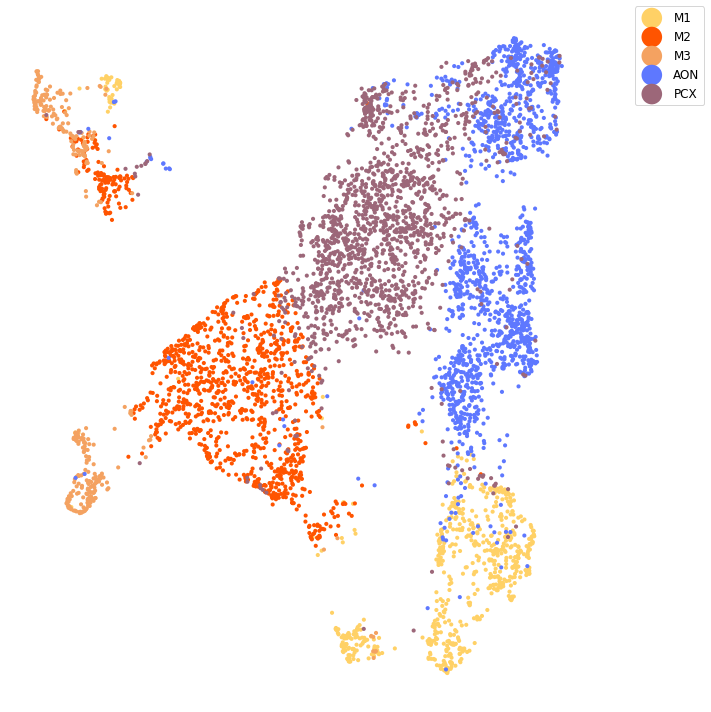

In [45]:
fig

In [46]:
fname = os.path.join(sim_folder,fn,'scVI_alginment_saras_colors')
fig.savefig(fname,bbox_inches='tight')

## UMAP coordinates to be saved

In [38]:
umap0 = latent_u[:,0]
umap1 = latent_u[:,1]

In [39]:
umap = pd.DataFrame(latent_u, index = imported_labels.index, columns = ['umap0','umap1'])

In [40]:
umap

umap0      umap1
AAAGGGCTCGTAGCTA-1   5.508290   3.976722
AAAGGTATCTATACGG-1  -3.193678  10.123593
AAAGTCCCATCGATGT-1  -2.639928  11.536343
AACAAGATCGCTACGG-1  -0.325146   3.650476
AACCAACCAGAGTTCT-1  -4.259235   2.284752
...                       ...        ...
AON_2_1495          12.574924   5.882503
AON_2_1496          13.614742   5.584785
AON_2_1497          13.697113  10.724633
AON_2_1498          11.499564   3.791195
AON_2_1499          14.457809  11.708692

[5161 rows x 2 columns]

In [41]:
fname = os.path.join(sim_folder,fn,'umap_combined.p')
umap.to_pickle(fname)

fname = os.path.join(sim_folder,fn,'st_umap.p')
umap.iloc[0:7504].to_pickle(fname)

fname = os.path.join(sim_folder,fn,'sim_umap.p')
umap.iloc[7504:10504].to_pickle(fname)